In [1]:
library(tidyverse)
library(cowplot)
library(blur)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
cols <- "ciiiccdli"
gs <- read_tsv("cones.evo.chi2.consistency.additive.gs.6082272.tsv", col_types = cols)
gm <- read_tsv("cones.evo.chi2.consistency.additive.gm.6082272.tsv", col_types = cols)
gi <- read_tsv("cones.evo.chi2.consistency.additive.gi.6082272.tsv", col_types = cols)
gi2 <- read_tsv("cones.evo.chi2.consistency.additive.gi2.6082272.tsv", col_types = cols)

C <- blur:::join_experiments(GI2 = gi2, GS = gs, GM = gm, GI = gi) %>%
    right_join(gi2, by = c("snp", "chr", "cm", "pos", "allele.1", "allele.2")) %>%
    mutate(consistency = ifelse(is.na(consistency), 0, consistency),
           consistency = factor(100 * consistency, levels = c("0","25","50","75","100")),
           p = pchisq(c, df = 1, lower.tail = F))

# Comparison to traditional GWAS

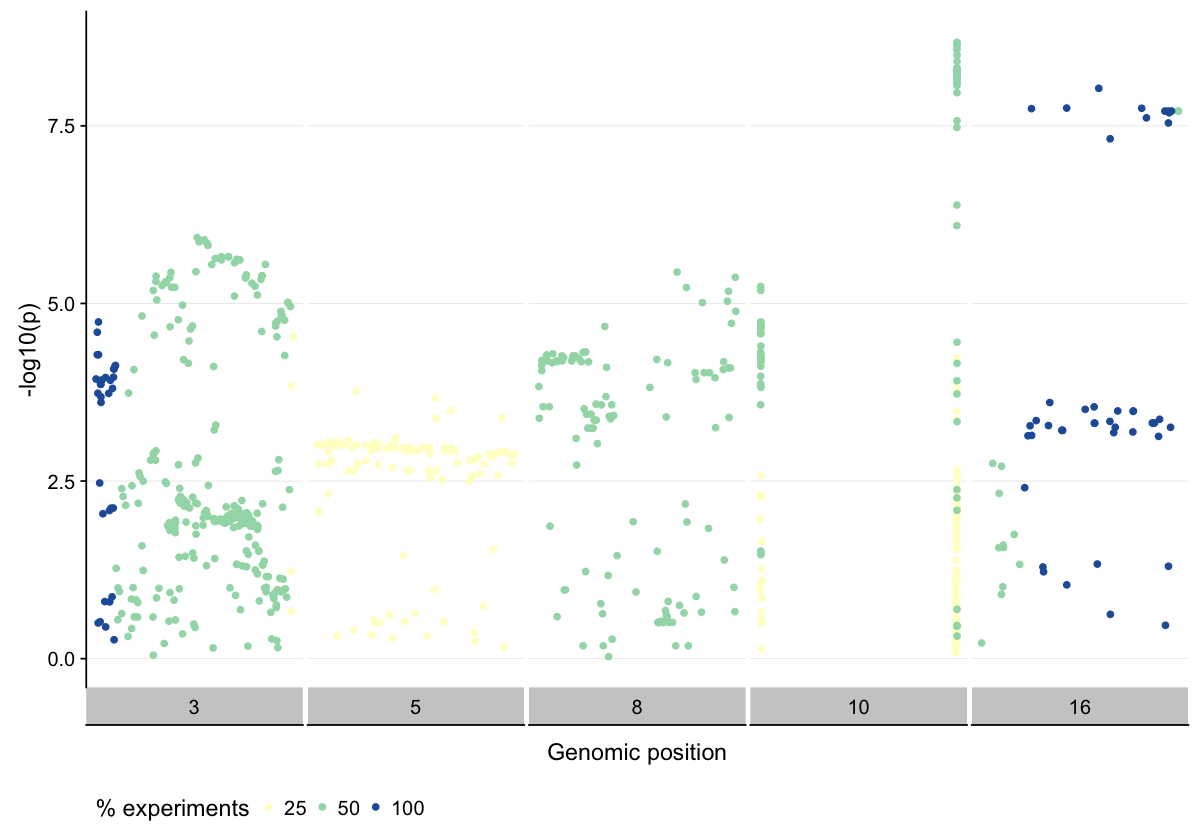

In [3]:
options(repr.plot.width=10, repr.plot.height=7)

C %>%
    filter(consistency != '0') %>%
    arrange(consistency) %>%
    ggplot(aes(x = pos, y = -log10(p), color = consistency)) +
        geom_point() +
        background_grid(major = "y", minor = "none") +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              legend.position = "bottom",
              panel.spacing.x = unit(0.2, "lines")) +
        labs(x = "Genomic position", y = "-log10(p)", color = "% experiments") +
        scale_color_manual(values = c("0"="gray80", "25"="#ffffcc", 
                                      "50"="#a1dab4", "75"="#41b6c4", 
                                      "100"="#225ea8")) +
        facet_grid(. ~ chr, scales = "free_x", switch = "x")

The SNPs we are selecting are not exclusively among the ones we would naturally select in a classical GWAS setting, although in general they display, at least, a moderate association.

# Validation: BCAC

We want to put SConES results in the context of another dataset, to see what the SNPs look like. We selected for that the European cohort of the BCAC ([download](http://bcac.ccge.medschl.cam.ac.uk/bcacdata/icogs/)). Note that (low-powered) GWAS have issues with replication, so low p-values in one experiment doesn't imply low p-values in another one.

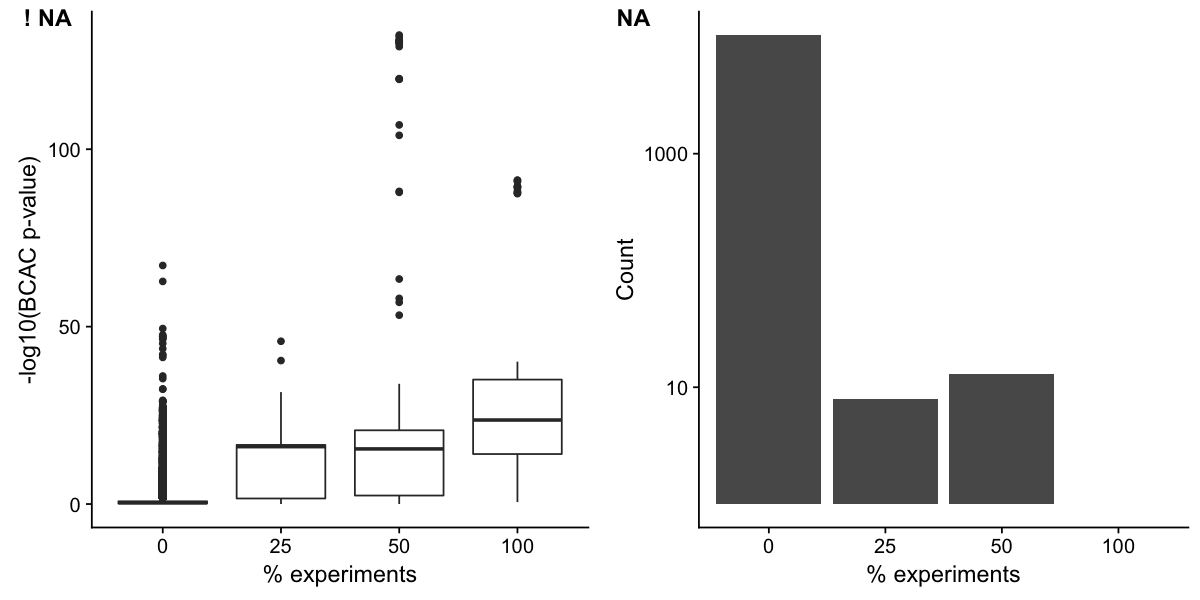

In [4]:
bcac <- read_tsv("../../data/bcac/icogs_bcac_public_results_euro.lite.txt", col_types = "cd") %>%
    rename(p_bcac = bcac_icogs1_risk_P1df) %>%
    right_join(C, by = c("phase3_1kg_id" = "snp")) %>%
    mutate(positive_bcac = p_bcac < 0.05/n(),
           positive_genesis = p < 0.05/n())

bp <- bcac %>%
    filter(!is.na(p_bcac)) %>%
    ggplot(aes(x = consistency, y = -log10(p_bcac))) +
        geom_boxplot() +
        labs(x = "% experiments", y = "-log10(BCAC p-value)")

h <- filter(bcac, is.na(p_bcac)) %>%
    ggplot(aes(x = consistency)) +
        geom_bar() +
        scale_y_log10() +
        labs(x = "% experiments", y = "Count")

options(repr.plot.width=10, repr.plot.height=5)
plot_grid(bp, h, labels=c("! NA","NA"))

It looks like we are selecting SNPs with very low p-values in the BCAC dataset too. This can be read in two positive ways:

- These SNPs are also moderately associated in GENESIS too, not enough to get a good, low-univariate p-value, but enough for SConES to pick up.
- SNPs with low p-values are connected in the underlying network, that's why SConES is picking them up, reinforcing our hypothesis.

Warning message:
“Removed 10390 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 10390 rows containing missing values (geom_point).”Warning message:
“Removed 10368 rows containing non-finite values (stat_bin).”Warning message:
“Removed 22 rows containing non-finite values (stat_bin).”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 8 rows containing missing values (geom_bar).”

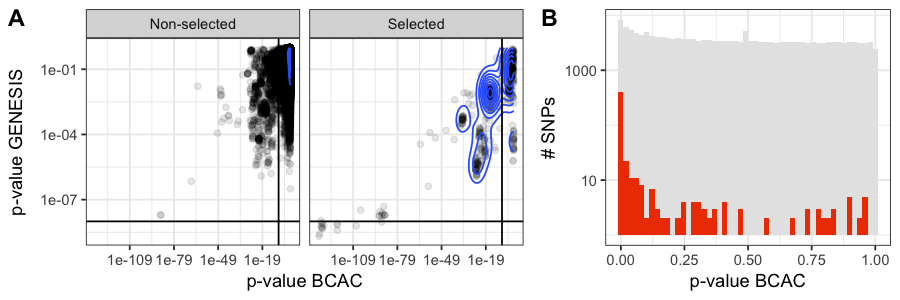

In [5]:
options(repr.plot.width = 7.5, repr.plot.height = 2.5)
df <- bcac %>%
    mutate(selected = ifelse(is.na(selected_GM), FALSE, selected_GM))

dist_2d <- mutate(df, selected = ifelse(selected, 'Selected', 'Non-selected')) %>%
    ggplot(aes(x = p_bcac, y = p)) +
        geom_point(alpha = 0.1) +
        stat_density_2d() +
        geom_vline(xintercept = 10^-8) +
        geom_hline(yintercept = 10^-8) +
        scale_x_log10() +
        scale_y_log10() +
        facet_grid(. ~ selected) +
        labs(x = 'p-value BCAC', y = 'p-value GENESIS', color = 'Selected') +
        theme_bw() +
        theme(legend.position = 'bottom')

dist_1d <- df %>%
    ggplot() +
        geom_histogram(data = filter(df, !selected), aes(p_bcac), fill = 'gray90', bins = 50) +
        geom_histogram(data = filter(df, selected), aes(p_bcac), fill = 'orangered2', bins = 50) +
        scale_y_log10() +
        labs(x = 'p-value BCAC', y = '# SNPs', fill = 'Selected') +
        theme_bw()

plot_grid(dist_2d, dist_1d, ncol = 2, rel_widths = c(1.45,1), labels = c('A','B'))

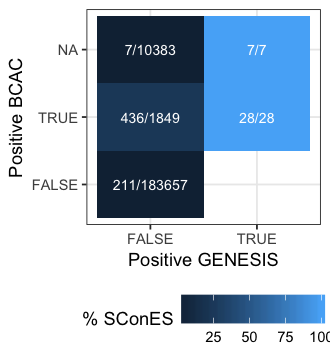

In [10]:
options(repr.plot.width = 2.75, repr.plot.height = 3)
bcac %>%
    mutate(selected = ifelse(is.na(selected_GS), FALSE, selected_GS)) %>%
    group_by(positive_bcac, positive_genesis) %>%
    summarize(label = paste(sum(selected), n(), sep = '/'),
              p = 100 * sum(selected)/n()) %>%
    ggplot(aes(positive_genesis, positive_bcac)) +
        geom_tile(aes(fill = p)) +
        geom_text(aes(label = label), size = 3, color = 'white') +
        labs(x = 'Positive GENESIS', y = 'Positive BCAC', fill = '% SConES') +
        theme_bw() +
        theme(legend.position = 'bottom')

When we look at the results in the GM network, it is clear that we more than half of the selected SNPs are interesting (i.e. would be selected in BCAC). There is a big share of them that have low p-values in both GENESIS and BCAC.

In [7]:
df %>% 
    mutate(significant = p_bcac < 10^-8,
           selected_GM = ifelse(is.na(selected_GM), FALSE, selected_GM)) %>%
    group_by(selected_GM,significant) %>%
    summarize(n = n(),
              median_p = median(p)) %>%
    ungroup %>%
    group_by(selected_GM) %>%
    mutate(p = n/sum(n) * 100)

selected_GM,significant,n,median_p,p
FALSE,FALSE,183727,0.2502390129,94.0424639
FALSE,TRUE,1271,0.0256542938,0.6505738
FALSE,NA,10368,0.2581844175,5.3069623
TRUE,FALSE,227,0.0639591014,40.6810036
TRUE,TRUE,309,0.0017858339,55.3763441
TRUE,NA,22,0.0004944957,3.9426523


Out of the SNPs selected in the GM network, a majority of them (55%) have a p-value < 10e-8 in BCAC.

Warning message:
“Removed 22 rows containing missing values (geom_point).”

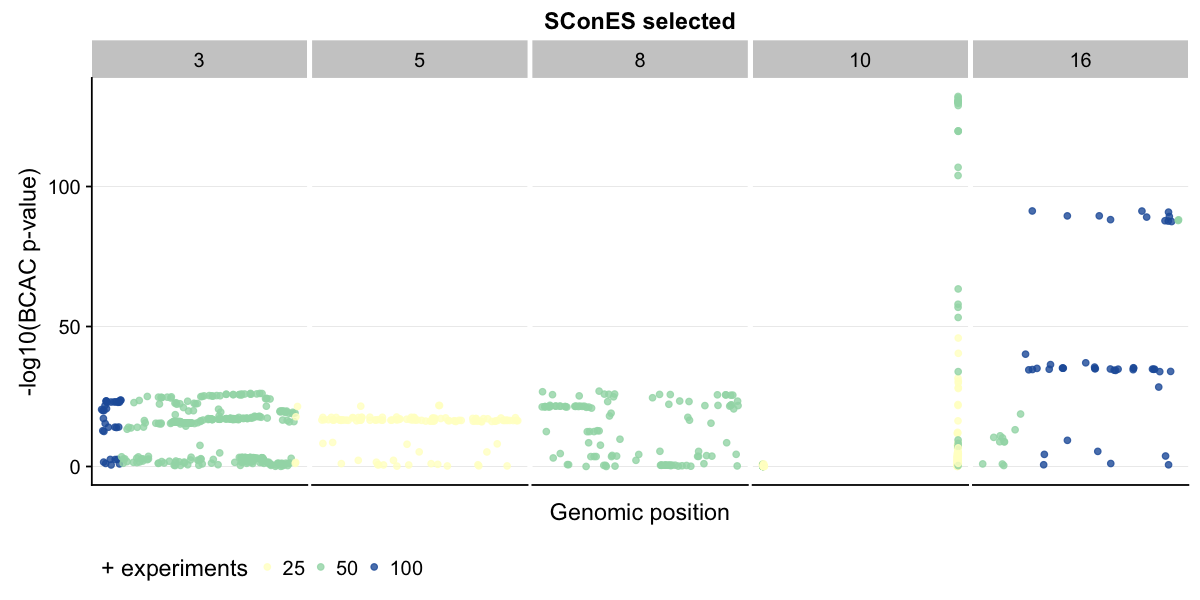

In [8]:
options(repr.plot.width=10, repr.plot.height=5)
filter(bcac, consistency != "0") %>%
    ggplot(aes(x = pos, y = -log10(p_bcac), color = consistency)) +
        geom_point(alpha = 0.8) +
        background_grid(major = "y", minor = "none") +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              legend.position = "bottom",
              panel.spacing.x = unit(0.2, "lines")) +
        labs(x = "Genomic position", y = "-log10(BCAC p-value)", 
             color = "+ experiments", title = "SConES selected") +
        scale_color_manual(values = c("25"="#ffffcc", "50"="#a1dab4", 
                                      "75"="#41b6c4", "100"="#225ea8"))  +
        facet_grid(. ~ chr, scales = "free_x")

The low-p-values are mostly concentrated in the chromosomic regions identified above in chromosomes 3, 5 and 8. But also regions in chromosome 10 and 16.

We can ask another question. How many of the SNPs selected by Bonferroni on the BCAC dataset are recovered by SConES?

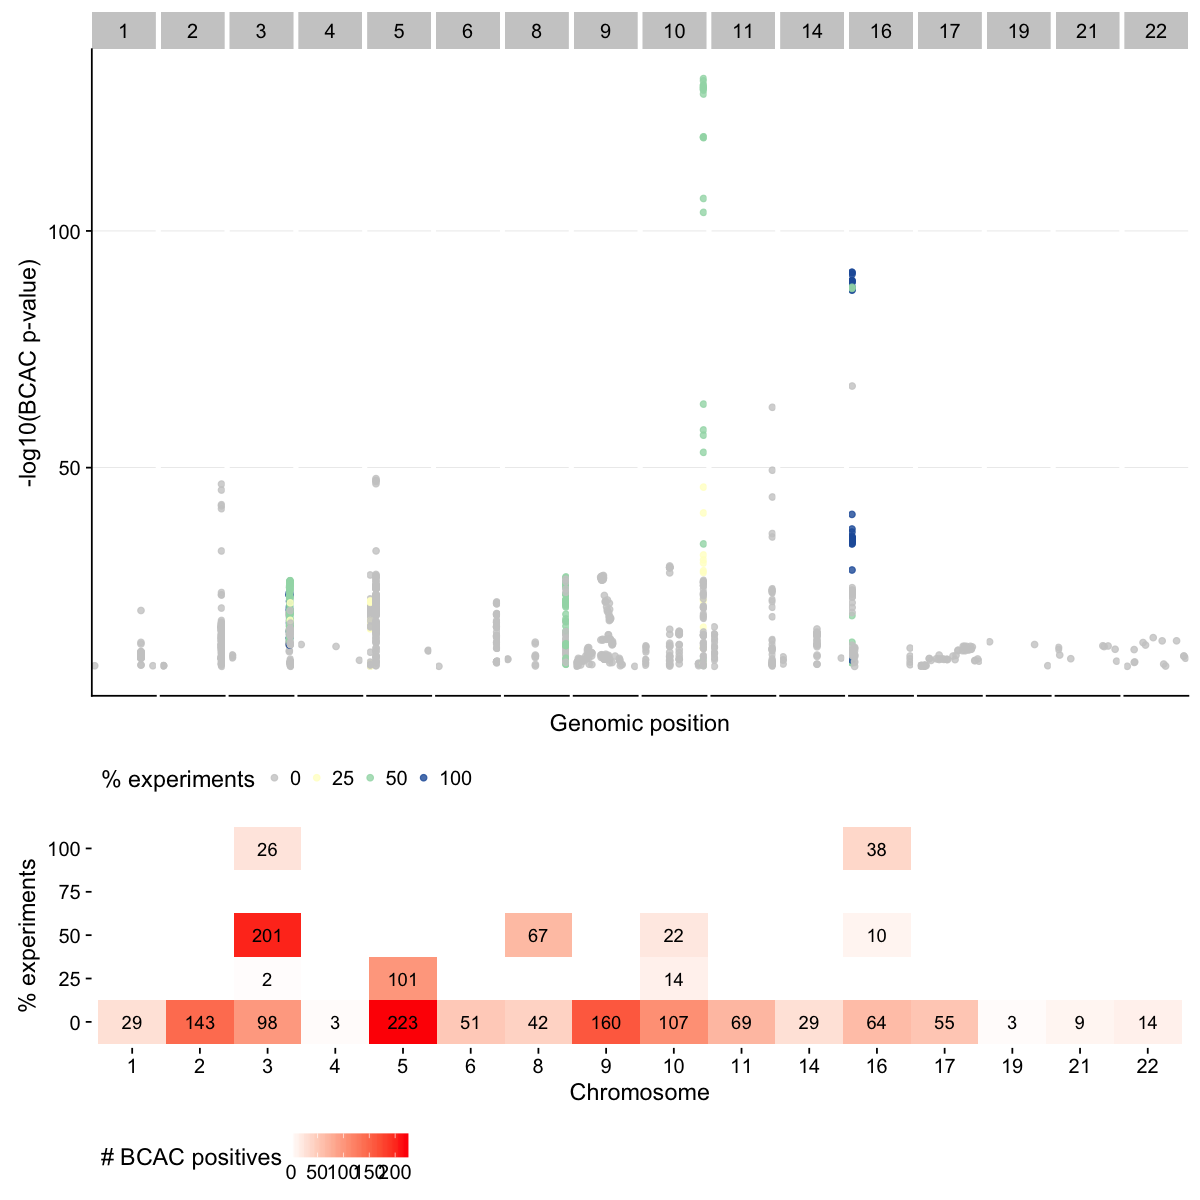

In [9]:
mh <- bcac %>%
    filter(p_bcac < 10^(-8)) %>%
    ggplot(aes(x = pos, y = -log10(p_bcac), color = consistency)) +
        geom_point(alpha = 0.8) +
        background_grid(major = "y", minor = "none") +
        theme(axis.text.x = element_blank(),
              axis.ticks.x = element_blank(),
              legend.position = "bottom",
              panel.spacing.x = unit(0.2, "lines")) +
        labs(x = "Genomic position", y = "-log10(BCAC p-value)", color = "% experiments") +
        scale_color_manual(values = c("0"="gray80", "25"="#ffffcc", 
                                      "50"="#a1dab4", "75"="#41b6c4", 
                                      "100"="#225ea8")) +
        facet_grid(. ~ chr, scales = "free_x")

ct <- bcac %>%
    filter(p_bcac < 10^(-8)) %>%
    select(consistency, chr) %>%
    table %>%
    as.data.frame %>%
    ggplot(aes(x = chr, y = consistency, fill = Freq)) +
        geom_tile() + 
        geom_text(aes(label = ifelse(Freq > 0, Freq, ""))) +
        labs(x = "Chromosome", y = "% experiments", fill = "# BCAC positives") +
        scale_fill_gradient(low = "white", high = "red")  +
        theme(legend.position = "bottom",
              axis.line = element_blank())

options(repr.plot.width=10, repr.plot.height=10)
plot_grid(mh, ct, nrow = 2, rel_heights = c(1, 0.48))

It looks like most of the SNPs in chromosomes 2, 3, 8 and 16 are detected. Around half of the ones in chromosomes 5 and 10. And we do quite bad in the rest, particularly in 6, 11 and 17, which hold a sizable amount of SNPs. Of course, the experimental conditions are not the same. It seems that BCAC also excluded BRCA1/2 carriers, as we can't find any mutation in their chromosomic regions.